### Here I play around with things for the sensitivity framework

In [1]:
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd


In [2]:

# determine the center position of the attractor at a given time
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos

def osci_pos_triang_func(stroke,time,frequency,width=0.5):
    osci_pos_triang=stroke/2*signal.sawtooth(2 * np.pi * frequency * time+np.pi/2,width=width)
    return osci_pos_triang

# determine the force for a given point in time using the transformation to position
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

def osci_force_func_tri(stroke,time,frequency,pos_vec,force_vec,width=0.5):
    osci_pos_triang = osci_pos_triang_func(stroke,time,frequency,width=width)
    return np.interp(osci_pos_triang,pos_vec,force_vec, left=None, right=None, period=None)



# normalization for used PSD
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

In [6]:
## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])
res_dict_side_by_side = pkl.load( open('/home/analysis_user/Results/Sensitivity/rbead_2.4e-06_sep_7.5e-06_height_0.p', 'rb'))


In [7]:
## where is the attractor?

int_time = 1
alpha = 1
sampling_frequency = 5000
time = np.arange(0,int_time,1/sampling_frequency)
#osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
separation = 7.5e-6 
lambda_par= 1e-6
force_x = res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0]
force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0]
pos_x = res_dict_side_by_side["posvec"]
#osci_force = np.interp(osci_pos,res_dict_side_by_side["posvec"],force_x, left=None, right=None, period=None)
#time2 = np.linspace(0,int_time,1001)
#osci_pos2 = stroke/2*np.sin(2*np.pi*time2*frequency)


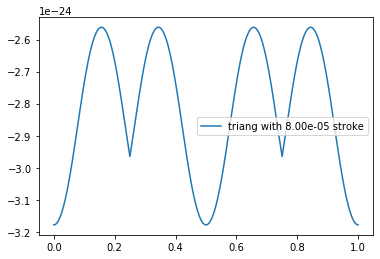

In [8]:
stroke1=80e-6
stroke2=100e-6
#plt.plot(time,osci_force_func(stroke1,time,1,pos_x,force_x_yuk), label =  "sin with %2.2e stroke" %stroke1)
plt.plot(time,osci_force_func_tri(stroke1,time,1,pos_x,force_x_yuk), label =  "triang with %2.2e stroke" %stroke1)
plt.legend()

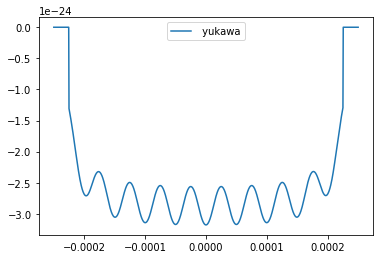

In [9]:
## plt.plot(pos_x,force_x, label = "newton")
plt.plot(pos_x,force_x_yuk, label = " yukawa")
plt.legend()

(0, 0.1)

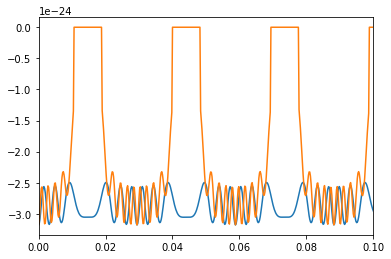

In [10]:
plt.plot(time,osci_force_func(300e-6,time,17,pos_x,force_x))
plt.plot(time,osci_force_func(500e-6,time,17,pos_x,force_x_yuk), label = " yukawa")

plt.xlim(0,0.100)

(0, 0.1)

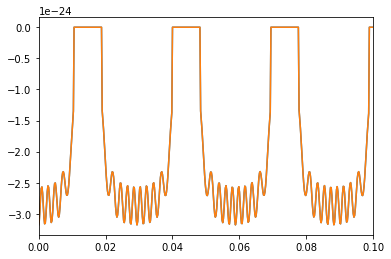

In [11]:
plt.plot(time,osci_force_func(500e-6,time,17,pos_x,force_x))
plt.plot(time,osci_force_func(500e-6,time,17,pos_x,force_x_yuk), label = " yukawa")

plt.xlim(0,0.100)

(1e-33, 1e-23)

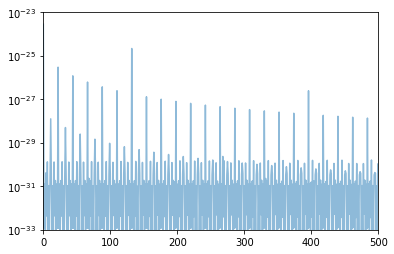

In [115]:
frequency = 11
psd_dat,freq = psd(osci_force_func(300e-6,time,frequency,pos_x,force_x), 
                   NFFT=len(osci_force_func(50e-6,time,frequency,pos_x,force_x)), Fs=5000, detrend="none",
        window=mlab.window_hanning, noverlap=0, pad_to=None)

psd_dat2,freq2 = psd(osci_force_func_tri(300e-6,time,frequency,pos_x,force_x_yuk),
                     NFFT=len(osci_force_func_tri(50e-6,time,frequency,pos_x,force_x_yuk)),Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)

#plt.plot(freq,np.sqrt(psd_dat))
plt.plot(freq2,np.sqrt(psd_dat2),alpha=0.5)
plt.yscale("log")
#plt.xscale("log")
plt.xlim(0,500)
plt.ylim(1e-33,1e-23)

#plt.xscale("log")

/home/analysis_user/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


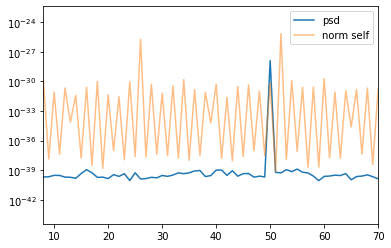

In [98]:
frequency=13
fft = np.fft.rfft(osci_force_func(300e-6,time,frequency,pos_x,force_x))
freq3 = np.fft.rfftfreq(5000, d=1./5000)
ps = fft*fft.conj().real*fft_norm(len(osci_force_func(300e-6,time,frequency,pos_x,force_x)),5000)**2

plt.plot(freq2,np.sqrt(psd_dat2),label="psd")
plt.plot(freq3,np.sqrt(ps),alpha=0.5, label = "norm self")
plt.yscale("log")
plt.xlim(8,70)
#plt.ylim(1e-40,1e-22)
plt.legend()
plt.show()

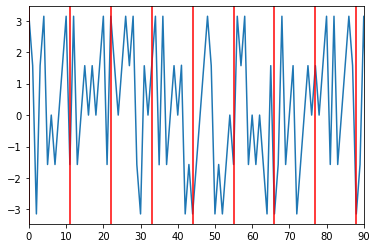

In [59]:
frequency = 11
plt.plot(np.angle(np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x))))
plt.xlim(0,90)
for i in np.arange(0,10,1):
    plt.axvline(frequency*i, color="red")

In [44]:
def function_response(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,plot=False):
    force_vec = force_vec * alpha
    sampling_frequency = 5000
    time = np.arange(0,int_time,1/sampling_frequency)
    psd_dat2,freq2 = psd(osci_force_func(stroke,time,frequency,pos_vec,force_vec), 
                         NFFT=len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)), 
                         Fs=5000, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    response_list=[]
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        freq_selec = np.arange(frequency,frequency*(no_harmonics+1),frequency)
        response_list.append(np.sqrt(psd_dat2[i*frequency]))
    if(plot==True):            
        plt.plot(freq_selec,response_list)
        plt.yscale("log")
        plt.xlim(0,frequency*no_harmonics+5)
        #print(response,i*frequency)
    return (response,freq_selec,response_list)

In [103]:
def function_response_2(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,bkg=False,plot=False):
    force_vec = force_vec * alpha
    sampling_frequency = 5000
    time = np.arange(0,int_time,1/sampling_frequency)
    fft_0 = np.fft.rfft(osci_force_func(stroke,time,frequency,pos_vec,force_vec))
    fft_1 = np.abs(fft_0)
    freq2 = np.fft.rfftfreq(5000, d=1./5000)
    psd_dat2 = fft_1*fft_1.conj().real*fft_norm(len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)),5000)**2
    
    
    response =0
    response_list=[]
    phase_list=[]
    if(bkg==True):frequency=frequency+2
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        freq_selec = np.arange(frequency,frequency*(no_harmonics+1),frequency)
        response_list.append(np.sqrt(psd_dat2[i*frequency]))
        phase_list.append(np.angle(fft_0[i*frequency]))
    if(plot==True):            
        plt.plot(freq_selec,response_list)
        plt.yscale("log")
        plt.xlim(0,frequency*no_harmonics+5)
        plt.show()
        plt.plot(freq_selec,np.divide(phase_list,np.pi),marker="*")
        plt.xlim(0,frequency*no_harmonics+5)
        #print(response,i*frequency)
    return (response,freq_selec,response_list,phase_list)

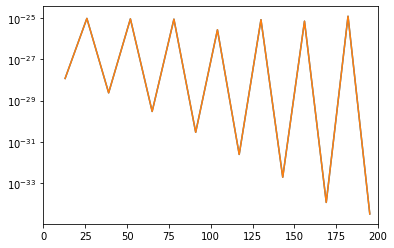

(5.617797751952375e-25,
 array([ 13,  26,  39,  52,  65,  78,  91, 104, 117, 130, 143, 156, 169,
        182, 195]),
 [1.1710771768783208e-28,
  9.314377946546593e-26,
  2.3688318063187032e-29,
  8.854053252834525e-26,
  2.9889447398907914e-30,
  8.564787490673024e-26,
  2.9422766391961948e-31,
  2.6312333340390897e-26,
  2.510900139637408e-32,
  8.094682333081848e-26,
  1.987056599021003e-33,
  6.846645691131661e-26,
  1.204965765130152e-34,
  1.185778682539287e-25,
  3.353197997211403e-35],
 [-1.5707963267961442,
  -3.141592653589791,
  1.5707963267947578,
  2.489044874283403e-15,
  -1.5707963268062841,
  -3.1415926535897922,
  1.570796326415262,
  5.1848321389554755e-15,
  -1.5707963206140962,
  5.04471746283227e-15,
  1.5707962397304867,
  -3.141592653589789,
  -1.570795091196205,
  -3.141592653589788,
  -1.570801409547729])

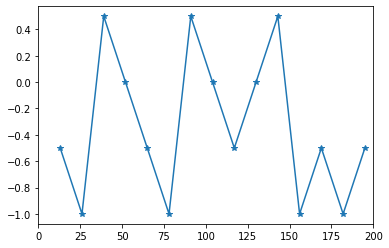

In [117]:
function_response(1,1,5000,pos_x,force_x_yuk,250e-6,13,15,plot=True)
function_response_2(1,1,5000,pos_x,force_x_yuk,250e-6,13,15,bkg=False,plot=True)


In [110]:
alpha_list=[]
noise_floor = 1e-18 # N
no_of_harmonics=3#np.arange(1,100,1)
stroke = np.arange(50e-6,550e-6,50e-6)
integration_time_simple = 1e5
for j in stroke:
    for i in np.geomspace(1,1e9,256):
        f = function_response(i,1,1,5000,pos_x,force_x_yuk,j,10,no_of_harmonics,plot=False)
        #print(f)
        if(f>(noise_floor*no_of_harmonics/np.sqrt(integration_time_simple))):
            #print("The maximum alpha is %2.2E with %.2d harmonics" %(i,j))
            alpha_list.append(i)
            break



TypeError: function_response() got multiple values for argument 'plot'

The minimum is at 1.24E+04 at 01 harmonics


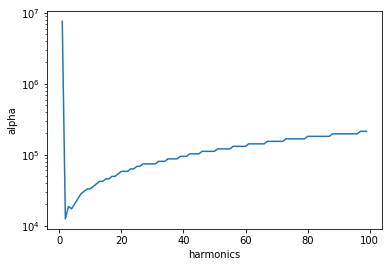

In [592]:
plt.plot(no_of_harmonics,alpha_list)            
plt.yscale("log")
plt.ylabel("alpha")
plt.xlabel("harmonics")
print("The minimum is at %2.2E at %.2d harmonics" %(np.min(alpha_list),np.argmin(alpha_list)))
plt.show()

The minimum is at 8.97E+03 


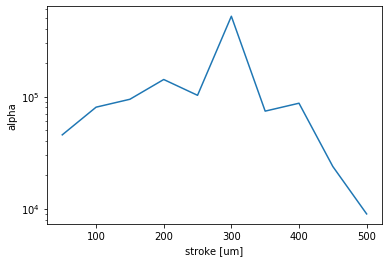

In [610]:
plt.plot(stroke*1e6,alpha_list)            
plt.yscale("log")
plt.ylabel("alpha")
plt.xlabel("stroke [um]")
print("The minimum is at %2.2E " %(np.min(alpha_list)))
plt.show()

/home/data_transfer/data_from_windows/20190812/Bead1/InitialTest/Data42.h5
No cantilever data


(0, 340)

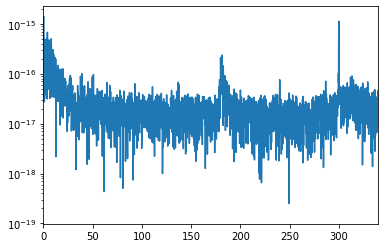

In [637]:
## load real noise spectrum
import numpy as np
import pickle as pickle
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
Year = "2019"
Month = "08"
Day = "12"
BeadNumber = 1
folder = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day
Data_File_Number=42
fname = folder+"/Bead"+str(BeadNumber)+"/InitialTest"+"/Data%d.h5" % Data_File_Number
print(fname)
BDF = BeadDataFile.BeadDataFile(fname)
fsamp=5000
res = 50000
#res=50000
data=BDF.xyz
data_det=signal.detrend(data)
y_1000=1*data_det[1]
z_1000=100*data_det[2]
xpsd, freqs = psd(data_det[0], Fs = fsamp, NFFT = res)
ypsd, freqs = psd(y_1000, Fs = fsamp, NFFT = res)
zpsd, freqs = psd(z_1000, Fs = fsamp, NFFT = res)
plt.plot(freqs,noise_floor/np.sqrt(xpsd[121*10])*np.sqrt(xpsd))
plt.yscale("log")
plt.xlim(0,340)


In [624]:
len(xpsd)

25001

In [641]:
def noise_response(data,frequency,no_harmonics,normalization=1):
    response=0
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(data[i*frequency*10])
        #print(response,i*frequency)
    return response*normalization

6.2711886904440515e-18
3.16227766016838e-20
1.7730784090655124e-18


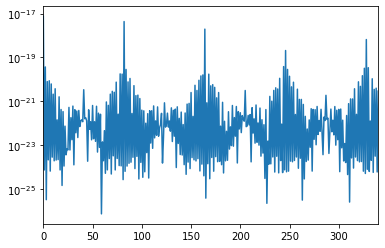

In [681]:
noise_floor = 1e-18 # N
integration_time_simple = 1000
no_of_harmonics=5
frequency=41
print(function_response(4e6,1,5000,pos_x,force_x_yuk,500e-6,frequency,no_of_harmonics,plot=True))
print(noise_floor/np.sqrt(integration_time_simple))
print(noise_response(np.sqrt(xpsd),frequency,no_of_harmonics,noise_floor/np.sqrt(xpsd[121*10])))

In [477]:
# my_to_do_list

# harmonics vs alpha (mo) - done
# comparison as a function of integration time (mo) - done
# comparison as a function of stroke with harmonics (mo) - done
# comparison vs real noise (mo) - basically implemented
# comparison for different frequencies (mo) - 
# make the script nice (di)
# do different lambda (di)
# do different separation (di)
# implement confidence intervall
# in and out (mi+do)
# second attractor (fr)
# change attractor - finger size, size, finger pattern (future)
# use peak height information for likelihood comparison